In [74]:
pyscenic_output <- read.csv("avg_auc_scores_filtered_F.csv")

In [1]:
pyscenic_output <- read.csv("pyscenic_output.csv")

In [75]:
cds <- readRDS("/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:01:31/cds.rds")

In [76]:
cds <- cds[,cds$'batch' != '20230925']

In [77]:
cds <- cds[,cds$final_Conditions != 'WT_Fem_CT28_1']
cds <- cds[,cds$final_Conditions != 'WT_Mal_CT28_1']

In [78]:
unique(cds$final_Conditions)
unique(cds$timepoint)
cds$final_timepoints <- sub(".*(ZT\\d+).*", "\\1", cds$final_Conditions)
cds$final_timepoints <- sub(".*(CT\\d+).*", "\\1", cds$final_timepoints)
unique(cds$final_timepoints)
unique(cds$replicate)
unique(cds$pseudo_replicate)
unique(cds$genotype)

[1] "MT_Mal_ZT20_2" "MT_Mal_ZT0_2"  "WT_Fem_CT16_1" "MT_Fem_ZT4_1" 
 [5] "MT_Fem_ZT0_1"  "WT_Mal_CT12_1" "MT_Mal_ZT16_1" "MT_Fem_CT0_1" 
 [9] "MT_Mal_ZT8_2"  "WT_Fem_CT4_1"  "MT_Fem_ZT12_1" "WT_Mal_CT20_1"
[13] "MT_Mal_ZT12_1" "WT_Fem_CT8_1"  "WT_Mal_CT4_1"  "MT_Mal_ZT4_1" 
[17] "MT_Fem_ZT8_2"  "MT_Mal_CT0_1"  "WT_Mal_CT0_1"  "MT_Fem_CT8_1" 
[21] "MT_Fem_CT16_1" "MT_Fem_ZT4_2"  "WT_Mal_CT8_1"  "MT_Mal_CT20_1"
[25] "MT_Fem_CT4_1"  "MT_Mal_CT8_1"  "MT_Mal_CT16_1" "MT_Fem_ZT12_2"
[29] "MT_Fem_ZT16_1" "MT_Mal_ZT16_2" "MT_Fem_ZT8_1"  "MT_Mal_ZT0_1" 
[33] "MT_Mal_ZT20_1" "MT_Fem_ZT0_2"  "MT_Mal_CT4_1"  "MT_Fem_CT20_1"
[37] "WT_Fem_CT12_1" "MT_Mal_ZT8_1"  "WT_Fem_CT0_1"  "WT_Fem_CT20_1"
[41] "MT_Mal_ZT12_2" "MT_Mal_ZT4_2"  "MT_Fem_ZT16_2" "WT_Mal_CT16_1"
[45] "MT_Fem_ZT20_1" "MT_Fem_CT12_1" "MT_Fem_ZT20_2" "MT_Mal_CT12_1"
[49] "WT_Mal_ZT8_1"  "WT_Fem_ZT16_2" "WT_Fem_ZT12_1" "WT_Fem_ZT12_2"
[53] "WT_Mal_ZT20_1" "WT_Mal_ZT8_2"  "WT_Fem_ZT4_1"  "WT_Fem_ZT8_1" 
[57] "WT_Mal_ZT20_2" "WT_Mal_ZT16_1" "WT_Mal_ZT12_2" "WT_Mal_ZT0_1" 
[61] "WT_Mal_ZT4_1"  "WT_Mal_ZT16_2" "WT_Fem_ZT8_2"  "WT_Fem_ZT20_2"
[65] "WT_Fem_ZT20_1" "WT_Fem_ZT0_1"  "WT_Mal_ZT12_1" "WT_Fem_ZT16_1"
[69] "WT_Mal_ZT4_2"  "WT_Fem_ZT4_2"  "WT_Mal_ZT0_2"  "WT_Fem_ZT0_2" 
[73] "WT_Mix_ZT8_1"  "WT_Mix_ZT16_1" "WT_Mix_ZT12_1" "MT_Mix_ZT4_2" 
[77] "MT_Mix_ZT20_1" "MT_Mix_ZT0_2"  "MT_Mix_ZT8_2"  "WT_Mix_ZT0_2" 
[81] "WT_Mix_ZT20_1" "MT_Mix_ZT20_2" "WT_Mix_ZT8_2"  "MT_Mix_ZT16_1"
[85] "MT_Mix_ZT16_2" "MT_Mix_ZT0_1"  "WT_Mix_ZT0_1"  "MT_Mix_ZT12_2"
[89] "WT_Mix_ZT12_2" "MT_Mix_ZT4_1"  "MT_Mix_ZT12_1" "MT_Mix_ZT8_1" 
[93] "WT_Mix_ZT4_2"  "WT_Mix_ZT20_2" "WT_Mix_ZT16_2" "WT_Mix_ZT4_1"

[1] 44 24 16  4  0 12 32 20  8 28 36 40

[1] "ZT20" "ZT0"  "CT16" "ZT4"  "CT12" "ZT16" "CT0"  "ZT8"  "CT4"  "ZT12"
[11] "CT20" "CT8"

[1] 2 1

NULL

[1] "per0"      "Wild-type"

# Make the pseudoreplicates

In [93]:
# ─── 0) Load libraries ───────────────────────────────────────────────
library(monocle)    # cds_aggregate_by_type(), exprs(), fData()
library(dplyr)
library(purrr)
library(ggplot2)
library(tibble)     # for rownames_to_column()

# ─── 1) Build pseudo-replicates & annotate celltype_Conditions ─────
number_of_replicates <- 2

cds$pseudo_replicate <- ave(
  cds$final_timepoints,
  cds$final_timepoints,
  cds$all_celltype,
  FUN = function(x) {
    n <- length(x)
    if (n == 1) {
      paste0(x, "_", sample(1:number_of_replicates, 1))
    } else {
      ids <- rep(1:number_of_replicates, length.out = n)
      ids <- sample(ids)
      paste0(x, "_", ids)
    }
  }
)

cds$Sum2 <- sapply(cds$pseudo_replicate, function(pr) {
  parts   <- strsplit(pr, "_")[[1]]
  base_tp <- as.numeric(gsub("\\D", "", parts[1]))
  rep_id  <- as.integer(parts[2])
  new_tp  <- if (rep_id == 1) base_tp else base_tp + 24
  as.character(new_tp)
})

cds$celltype_Conditions <- paste0(cds$all_celltype, "_", cds$Sum2)

In [94]:
data <- data.frame(Cell = pyscenic_output$Cell)

In [95]:
matching <- match(data$Cell, cds$sample)
valid <- !is.na(matching)
data$celltype[valid] <- cds$all_celltype[matching[valid]]
data$light_condition[valid] <- cds$light_condition[matching[valid]]
data$celltype[is.na(data$celltype)] <- "Unannotated"
data$pseudo_replicate[valid] <- cds$Sum2[matching[valid]]
data$genotype[valid] <- cds$genotype[matching[valid]]

In [96]:
library(dplyr)
library(tidyr)
filtered_result <- left_join(data, pyscenic_output, by = "Cell")

In [97]:
# Get column names
cols <- names(filtered_result)
# Determine the TF score columns: all columns after "genotype"
start_idx <- which(cols == "genotype") + 1
tf_columns <- cols[start_idx:length(cols)]

averaged_result <- filtered_result %>%
  group_by(celltype, pseudo_replicate, genotype, light_condition) %>%
  summarise(across(all_of(tf_columns), \(x) mean(x, na.rm = TRUE)),
            .groups = "drop")

head(averaged_result)


celltype,pseudo_replicate,genotype,light_condition,Atf3...,B.H2...,CG3919...,Dad...,Dll...,Dr...,⋯,Pph13...,fd96Cb...,pb...,bin...,otp...,CrebB...,SoxN...,odd...,ems...,nau...
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AL-PN,0,Wild-type,DD,0.02678294,0.01369460,0.008141464,0.02397798,0.01997337,0.010554857,⋯,0.007034422,0.04224668,0.02608485,0.06860465,0.03754752,0.012062984,0.004931973,0.01413344,0.01794514,0.06750877
AL-PN,0,Wild-type,LD,0.02591291,0.01418665,0.016650590,0.03301189,0.02239638,0.009039221,⋯,0.009552649,0.04639050,0.02554806,0.08073590,0.05778146,0.014675145,0.011281838,0.01880249,0.01861436,0.05533417
AL-PN,0,per0,DD,0.02406206,0.01278445,0.006875734,0.02248214,0.01589890,0.043698410,⋯,0.000000000,0.00000000,0.02557709,0.03995478,0.01818117,0.013806202,0.011295681,0.03279231,0.01317603,0.07034615
AL-PN,0,per0,LD,0.02669569,0.01338254,0.006739782,0.02893275,0.01582307,0.010443696,⋯,0.000000000,0.04537427,0.02605479,0.06700985,0.03993936,0.010241279,0.008077243,0.01831093,0.02283740,0.08410045
AL-PN,12,Wild-type,DD,0.02591056,0.01586851,0.005950983,0.02487807,0.01878377,0.008262880,⋯,0.014389535,0.05011951,0.02487086,0.08936980,0.02945633,0.011358850,0.002445552,0.01728978,0.01699165,0.05999856
AL-PN,12,Wild-type,LD,0.02739513,0.01524418,0.008915724,0.02646208,0.02008616,0.005948662,⋯,0.000000000,0.04659252,0.03101690,0.09428435,0.04950027,0.008595804,0.002607251,0.01803274,0.01395238,0.06921624


In [85]:
saveRDS(averaged_result, "averaged_result_F_1.rds")

In [92]:
saveRDS(averaged_result, "averaged_result_F_2.rds")

In [98]:
saveRDS(averaged_result, "averaged_result_F_3.rds")

In [99]:
averaged_result <- readRDS("averaged_result_F_1.rds")

In [ ]:
averaged_result <- readRDS("averaged_result_F_2.rds")

In [ ]:
averaged_result <- readRDS("averaged_result_F_3.rds")

In [ ]:
# run_metacycle2d2D.R
# This script runs MetaCycle::meta2d with JTK, ARS, and LS methods
# on TF activity scores (SCENIC output) across cell types, genotypes, and light conditions.

# 1) Load required libraries
library(MetaCycle)
library(dplyr)
library(tibble)

# 2) Define parameters
genotypes <- c('Wild-type', 'per0')
light_conditions <- c('LD', 'DD')
cycle_methods <- c('JTK'
                   ,'ARS'
                   ,'LS'
                   )
period_min <- 24
period_max <- 24

# 3) Prepare data: ensure averaged_result is loaded and convert pseudo_replicate to numeric time
averaged_result <- averaged_result %>%
  mutate(time = as.numeric(pseudo_replicate))

# Initialize container for all outputs
all_results <- list()

# 4) Get distinct condition combinations
conditions_df <- averaged_result %>%
  distinct(celltype, genotype, light_condition)

# Loop through each condition
for (i in seq_len(nrow(conditions_df))) {
  ct   <- conditions_df$celltype[i]
  geno <- conditions_df$genotype[i]
  lc   <- conditions_df$light_condition[i]

  # Subset and sort by time
  sub <- averaged_result %>%
    filter(celltype == ct, genotype == geno, light_condition == lc) %>%
    arrange(time)

  # Skip if fewer than 3 time points
  if (nrow(sub) < 3) {
    message('Skipping ', ct, ' ', geno, ' ', lc, ': fewer than 3 time points')
    next
  }

  # Extract TF score matrix (rows=timepoints, cols=TFs)
  tf_mat <- sub %>%
    select(-celltype, -genotype, -light_condition, -pseudo_replicate, -time) %>%
    as.matrix()

  # Remove TFs with any missing values
  valid_tfs <- colSums(is.na(tf_mat)) == 0
  if (!any(valid_tfs)) {
    message('Skipping ', ct, ' ', geno, ' ', lc, ': all TFs contain NAs')
    next
  }
  tf_mat <- tf_mat[, valid_tfs, drop = FALSE]

  # Prepare input for meta2d: genes as rows
  input_df <- data.frame(
    Gene = colnames(tf_mat),
    as.data.frame(t(tf_mat)),
    stringsAsFactors = FALSE
  )

  # Run meta2d with warnings suppressed and errors caught
  res <- tryCatch({
    suppressWarnings(
      meta2d(
        infile     = 'inmemory',
        inDF       = input_df,
        filestyle  = 'txt',
        outdir     = paste0('MetaCycle_', ct, '_', geno, '_', lc),
        timepoints = sub$time,
        cycMethod  = cycle_methods,
        minper     = period_min,
        maxper     = period_max,
        outputFile = FALSE
      )
    )
  }, error = function(e) {
    message('Error in meta2d for ', ct, ' ', geno, ' ', lc, ': ', e$message)
    NULL
  })

  # Skip on error
  if (is.null(res)) next

  # Extract integrated results
  out_df <- res$meta
  out_df$celltype        <- ct
  out_df$genotype        <- geno
  out_df$light_condition <- lc

  # Store
  key <- paste(ct, geno, lc, sep = '_')
  all_results[[key]] <- out_df
}

# 5) Combine and save
if (length(all_results) > 0) {
  combined <- bind_rows(all_results)
  #write.csv(combined, 'all_MetaCycle_TF_rhythmicity.csv', row.names = FALSE)
  combined
} else {
  stop('No rhythmicity results generated.')
}


In [46]:
head(combined)

,CycID,ARS_pvalue,ARS_BH.Q,ARS_period,ARS_adjphase,ARS_amplitude,JTK_pvalue,JTK_BH.Q,JTK_period,JTK_adjphase,⋯,meta2d_pvalue,meta2d_BH.Q,meta2d_period,meta2d_phase,meta2d_Base,meta2d_AMP,meta2d_rAMP,celltype,genotype,light_condition
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1...1,Abd.B...,0.2006157,0.7177950,24,20.158711,0.0020532058,0.9155428,1,24,22,⋯,0.7538210,1,24,19.444726,0.02147812,0.0021566571,0.0021566571,AL-PN,Wild-type,DD
2...2,Atf3...,0.2869894,0.7834034,24,1.457180,0.0006676458,0.6957053,1,24,2,⋯,0.7010314,1,24,1.114288,0.02580249,0.0007298681,0.0007298681,AL-PN,Wild-type,DD
3...3,B.H1...,0.2751127,0.7827151,24,3.481320,0.0009848326,0.5179027,1,24,6,⋯,0.6537463,1,24,4.489784,0.01653341,0.0011386923,0.0011386923,AL-PN,Wild-type,DD
4...4,B.H2...,0.6677278,0.9002786,24,11.647175,0.0014848960,1.0000000,1,24,10,⋯,0.9918320,1,24,12.349737,0.03066549,0.0015462762,0.0015462762,AL-PN,Wild-type,DD
5...5,CG11294...,0.6685237,0.9002786,24,14.477334,0.0042471204,1.0000000,1,24,12,⋯,0.9911294,1,24,13.076899,0.07040278,0.0043440661,0.0043440661,AL-PN,Wild-type,DD
6...6,CG9727...,0.5378212,0.8766875,24,3.519502,0.0017349467,0.6957053,1,24,2,⋯,0.9149629,1,24,3.238566,0.01777351,0.0020629007,0.0020629007,AL-PN,Wild-type,DD


In [ ]:
write.csv(combined, 'all_MetaCycle_TF_rhythmicity_F_1.csv', row.names = FALSE)

In [ ]:
write.csv(combined, 'all_MetaCycle_TF_rhythmicity_F_2.csv', row.names = FALSE)

In [ ]:
write.csv(combined, 'all_MetaCycle_TF_rhythmicity_F_3.csv', row.names = FALSE)

In [58]:
getwd()

[1] "/lustre/fs4/yng_lab/scratch/pkim/Singlecell/2025:03:27"

In [54]:
combined_1 <- read.csv("all_MetaCycle_TF_rhythmicity_F_1.csv")

In [55]:
combined_2 <- read.csv("all_MetaCycle_TF_rhythmicity_F_2.csv")

In [56]:
combined_3 <- read.csv("all_MetaCycle_TF_rhythmicity_F_3.csv")

In [18]:
print(head(combined_1))

       CycID ARS_pvalue  ARS_BH.Q ARS_period ARS_adjphase ARS_amplitude
1   Abd.B...  0.7856298 0.9094098         24   17.2789067  0.0009694066
2    Atf3...  0.4128267 0.8782777         24    0.4422076  0.0001751902
3    B.H1...  0.4912103 0.8782777         24    6.1462635  0.0006257022
4 BEAF.32...  0.7016125 0.9093225         24   18.7997725  0.0003088056
5 CG12942...  0.3615942 0.8764023         24    1.3910251  0.0017580778
6 CG15812...  0.7541374 0.9094098         24    8.4095102  0.0002890180
  JTK_pvalue JTK_BH.Q JTK_period JTK_adjphase JTK_amplitude LS_pvalue LS_BH.Q
1  1.0000000        1         24           18  0.0013608040 1.0000000       1
2  0.3772149        1         24            2  0.0001069414 0.9245909       1
3  0.9155428        1         24            8  0.0009173489 0.9970461       1
4  1.0000000        1         24           18  0.0004288718 0.9998857       1
5  1.0000000        1         24            6  0.0014625750 0.9144128       1
6  0.6957053        1       

In [20]:
# merge_MetaCycle_results.R
# This script reads three MetaCycle output CSVs and computes average p-values and circular mean phases.

# 1) Load required libraries
library(dplyr)
library(tidyr)

# 2) Read the three MetaCycle result files
combined_1 <- read.csv("all_MetaCycle_TF_rhythmicity_F_1.csv", stringsAsFactors = FALSE)
combined_2 <- read.csv("all_MetaCycle_TF_rhythmicity_F_2.csv", stringsAsFactors = FALSE)
combined_3 <- read.csv("all_MetaCycle_TF_rhythmicity_F_3.csv", stringsAsFactors = FALSE)

# 3) Select and rename key rhythmicity columns to distinguish runs
rename_cols <- function(df, run) {
  df %>%
    rename(
      pval_run = meta2d_pvalue,
      phase_run = meta2d_phase
    ) %>%
    select(CycID, celltype, genotype, light_condition, pval_run, phase_run) %>%
    rename_with(~ paste0(.x, "_", run), c(pval_run, phase_run))
}

df1 <- rename_cols(combined_1, 1)
df2 <- rename_cols(combined_2, 2)
df3 <- rename_cols(combined_3, 3)

# 4) Merge all three on identifiers
merged <- df1 %>%
  inner_join(df2, by = c("CycID", "celltype", "genotype", "light_condition")) %>%
  inner_join(df3, by = c("CycID", "celltype", "genotype", "light_condition"))

# 5) Define circular mean for phases (0–24 h)
circ_mean_hours <- function(phases) {
  radians <- phases / 24 * 2 * pi
  ang <- atan2(mean(sin(radians), na.rm = TRUE), mean(cos(radians), na.rm = TRUE))
  (ang %% (2 * pi)) / (2 * pi) * 24
}

# 6) Compute average p-value and average phase
result_avg <- merged %>%
  rowwise() %>%
  mutate(
    avg_p = mean(c(pval_run_1, pval_run_2, pval_run_3), na.rm = TRUE),
    avg_phase = circ_mean_hours(c(phase_run_1, phase_run_2, phase_run_3))
  ) %>%
  ungroup()

# 7) Optional: filter by significance
result_sig <- result_avg %>%
  filter(avg_p < 0.05)

# 8) Save results
write.csv(result_avg, "TF_rhythmicity_avg_all_M.csv", row.names = FALSE)
write.csv(result_sig, "TF_rhythmicity_avg_sig_M.csv", row.names = FALSE)


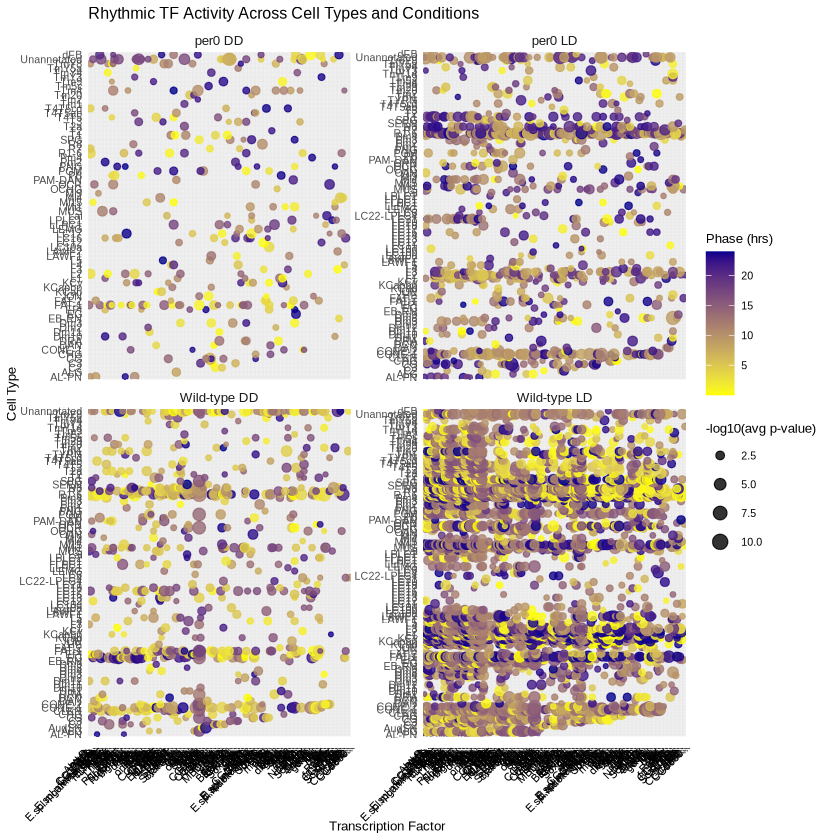

In [2]:
# merge_and_plot_MetaCycle_results.R
# This script merges three MetaCycle output runs, computes average p-values and circular mean phases,
# and visualizes rhythmic TF activity across cell types and conditions.

# 1) Load required libraries
library(dplyr)
library(tidyr)
library(ggplot2)

# 2) Read the three MetaCycle result files
combined_1 <- read.csv("all_MetaCycle_TF_rhythmicity_F_1.csv", stringsAsFactors = FALSE)
combined_2 <- read.csv("all_MetaCycle_TF_rhythmicity_F_2.csv", stringsAsFactors = FALSE)
combined_3 <- read.csv("all_MetaCycle_TF_rhythmicity_F_3.csv", stringsAsFactors = FALSE)

# 3) Define circular mean function for phase (0–24 h)
circ_mean_hours <- function(phases) {
  radians <- phases/24 * 2 * pi
  mean_angle <- atan2(mean(sin(radians), na.rm=TRUE), mean(cos(radians), na.rm=TRUE))
  mean_hour <- (mean_angle %% (2*pi)) / (2*pi) * 24
  return(mean_hour)
}

# 4) Merge datasets on identifiers
id_cols <- c("CycID", "celltype", "genotype", "light_condition")
merged <- combined_1 %>%
  select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
  rename(p1 = meta2d_pvalue, phase1 = meta2d_phase) %>%
  inner_join(
    combined_2 %>% select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
      rename(p2 = meta2d_pvalue, phase2 = meta2d_phase),
    by = id_cols
  ) %>%
  inner_join(
    combined_3 %>% select(all_of(c(id_cols, "meta2d_pvalue", "meta2d_phase"))) %>%
      rename(p3 = meta2d_pvalue, phase3 = meta2d_phase),
    by = id_cols
  )

# 5) Compute average p-value and phase
merged <- merged %>%
  rowwise() %>%
  mutate(
    avg_p = mean(c(p1, p2, p3), na.rm = TRUE),
    avg_phase = circ_mean_hours(c(phase1, phase2, phase3))
  ) %>%
  ungroup()

# 6) Save merged averaged results
write.csv(merged, "TF_rhythmicity_avg_M.csv", row.names = FALSE)

# 7) Plot rhythmic TFs for each cell type and condition
sig_results <- merged %>%
  filter(avg_p < 0.05) %>%
  arrange(celltype, CycID)

sig_results$celltype <- factor(sig_results$celltype, levels = unique(sig_results$celltype))
sig_results$CycID    <- factor(sig_results$CycID, levels = unique(sig_results$CycID))

sig_results <- sig_results %>%
  mutate(Condition = paste(genotype, light_condition))

p <- ggplot(sig_results, aes(x = CycID, y = celltype,
                             color = avg_phase, size = -log10(avg_p))) +
  geom_point(alpha = 0.8) +
  scale_color_gradient(low = "yellow", high = "blue4", name = "Phase (hrs)") +
  scale_size(range = c(1, 4), name = "-log10(avg p-value)") +
  facet_wrap(~ Condition, scales = "free_y") +
  theme_minimal(base_size = 8) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    strip.text = element_text(size = 8)
  ) +
  labs(
    title = "Rhythmic TF Activity Across Cell Types and Conditions",
    x = "Transcription Factor",
    y = "Cell Type"
  )

print(p)


In [ ]:
# 7) Define cyclic color palette
phase_colors <- hsv(seq(0, 1, length.out = 100), 1, 1)

# on your averaged tibble
sig_results$Condition <- factor(
  paste(sig_results$genotype, sig_results$light_condition),
  levels = c("Wild-type LD", "Wild-type DD", "per0 LD", "per0 DD")
)

# 8) Plot rhythmic TFs with cyclic phase scale
p <- ggplot(sig_results, aes(x = celltype, y = CycID,
                             color = avg_phase, size = -log10(avg_p))) +
  geom_point(alpha = 0.8) +
  scale_color_gradientn(
    colors = phase_colors,
    limits = c(0, 24),
    breaks = c(0, 6, 12, 18, 24),
    name = "Phase (hrs)"
  ) +
  scale_size(range = c(1, 4), name = "-log10(avg p-value)") +
  facet_wrap(~ Condition, scales = "free_y") +
  theme_minimal(base_size = 6) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
    strip.text   = element_text(size = 8)
  ) +
  labs(
    title = "Rhythmic TF Activity Across Cell Types and Conditions",
    x = "Transcription Factor",
    y = "Cell Type"
  )

print(p)

In [3]:
options(repr.plot.width = 20,
        repr.plot.height = 25,
        repr.plot.res    = 500)
   # resolution in DPI

# Make background white
par(bg = "white")


In [4]:
library(stringr)

sig_results <- sig_results %>%
  mutate(CycID = str_remove(CycID, "\\.{3}$"))


In [5]:
library(dplyr)
  #filter(genotype == "Wild-type", light == "LD")

# Count how many unique rhythmic TF activities were detected in WT DD
n_rhythmic <- sig_results %>% pull(CycID) %>% unique() %>% length()
cat("Total number of rhythmic TF activities detected:", n_rhythmic, "\n")

# For each TF, count the number of unique cell types in which it appears
tf_abundance <- sig_results %>%
  group_by(CycID) %>%
  summarize(num_celltypes = n_distinct(celltype), .groups = "drop") %>%
  arrange(desc(num_celltypes))

# Get the top 17 TFs that are most abundant (detected in the highest number of cell types)
top_20_tf <- tf_abundance %>% slice_head(n = 50)

# Display the top 17 TFs
print(top_20_tf)


Total number of rhythmic TF activities detected: 195 
# A tibble: 50 × 2
   CycID     num_celltypes
   <chr>             <int>
 1 onecut               57
 2 NfI                  56
 3 cwo                  56
 4 srp                  55
 5 Pur.alpha            53
 6 Sox102F              53
 7 Mitf                 50
 8 Pdp1                 48
 9 luna                 48
10 tai                  48
# ℹ 40 more rows


In [6]:
print(top_20_tf$CycID)

 [1] "onecut"    "NfI"       "cwo"       "srp"       "Pur.alpha" "Sox102F"  
 [7] "Mitf"      "Pdp1"      "luna"      "tai"       "zfh2"      "hth"      
[13] "jim"       "lola"      "Hnf4"      "Hr78"      "CG12605"   "EcR"      
[19] "Hsf"       "Rel"       "retn"      "Myb"       "Hr38"      "da"       
[25] "CG30020"   "Atf3"      "B.H2"      "disco"     "grn"       "Met"      
[31] "Su.H."     "drm"       "SREBP"     "slou"      "CrebA"     "Sry.delta"
[37] "scro"      "B.H1"      "cad"       "pad"       "kay"       "vnd"      
[43] "vri"       "Kah"       "Myc"       "pnr"       "bowl"      "repo"     
[49] "maf.S"     "Hr96"     


In [7]:
length(tf_order)

[1] 50

In [8]:
options(repr.plot.width = 5,
        repr.plot.height = 4,
        repr.plot.res    = 500)
   # resolution in DPI

# Make background white
par(bg = "white")


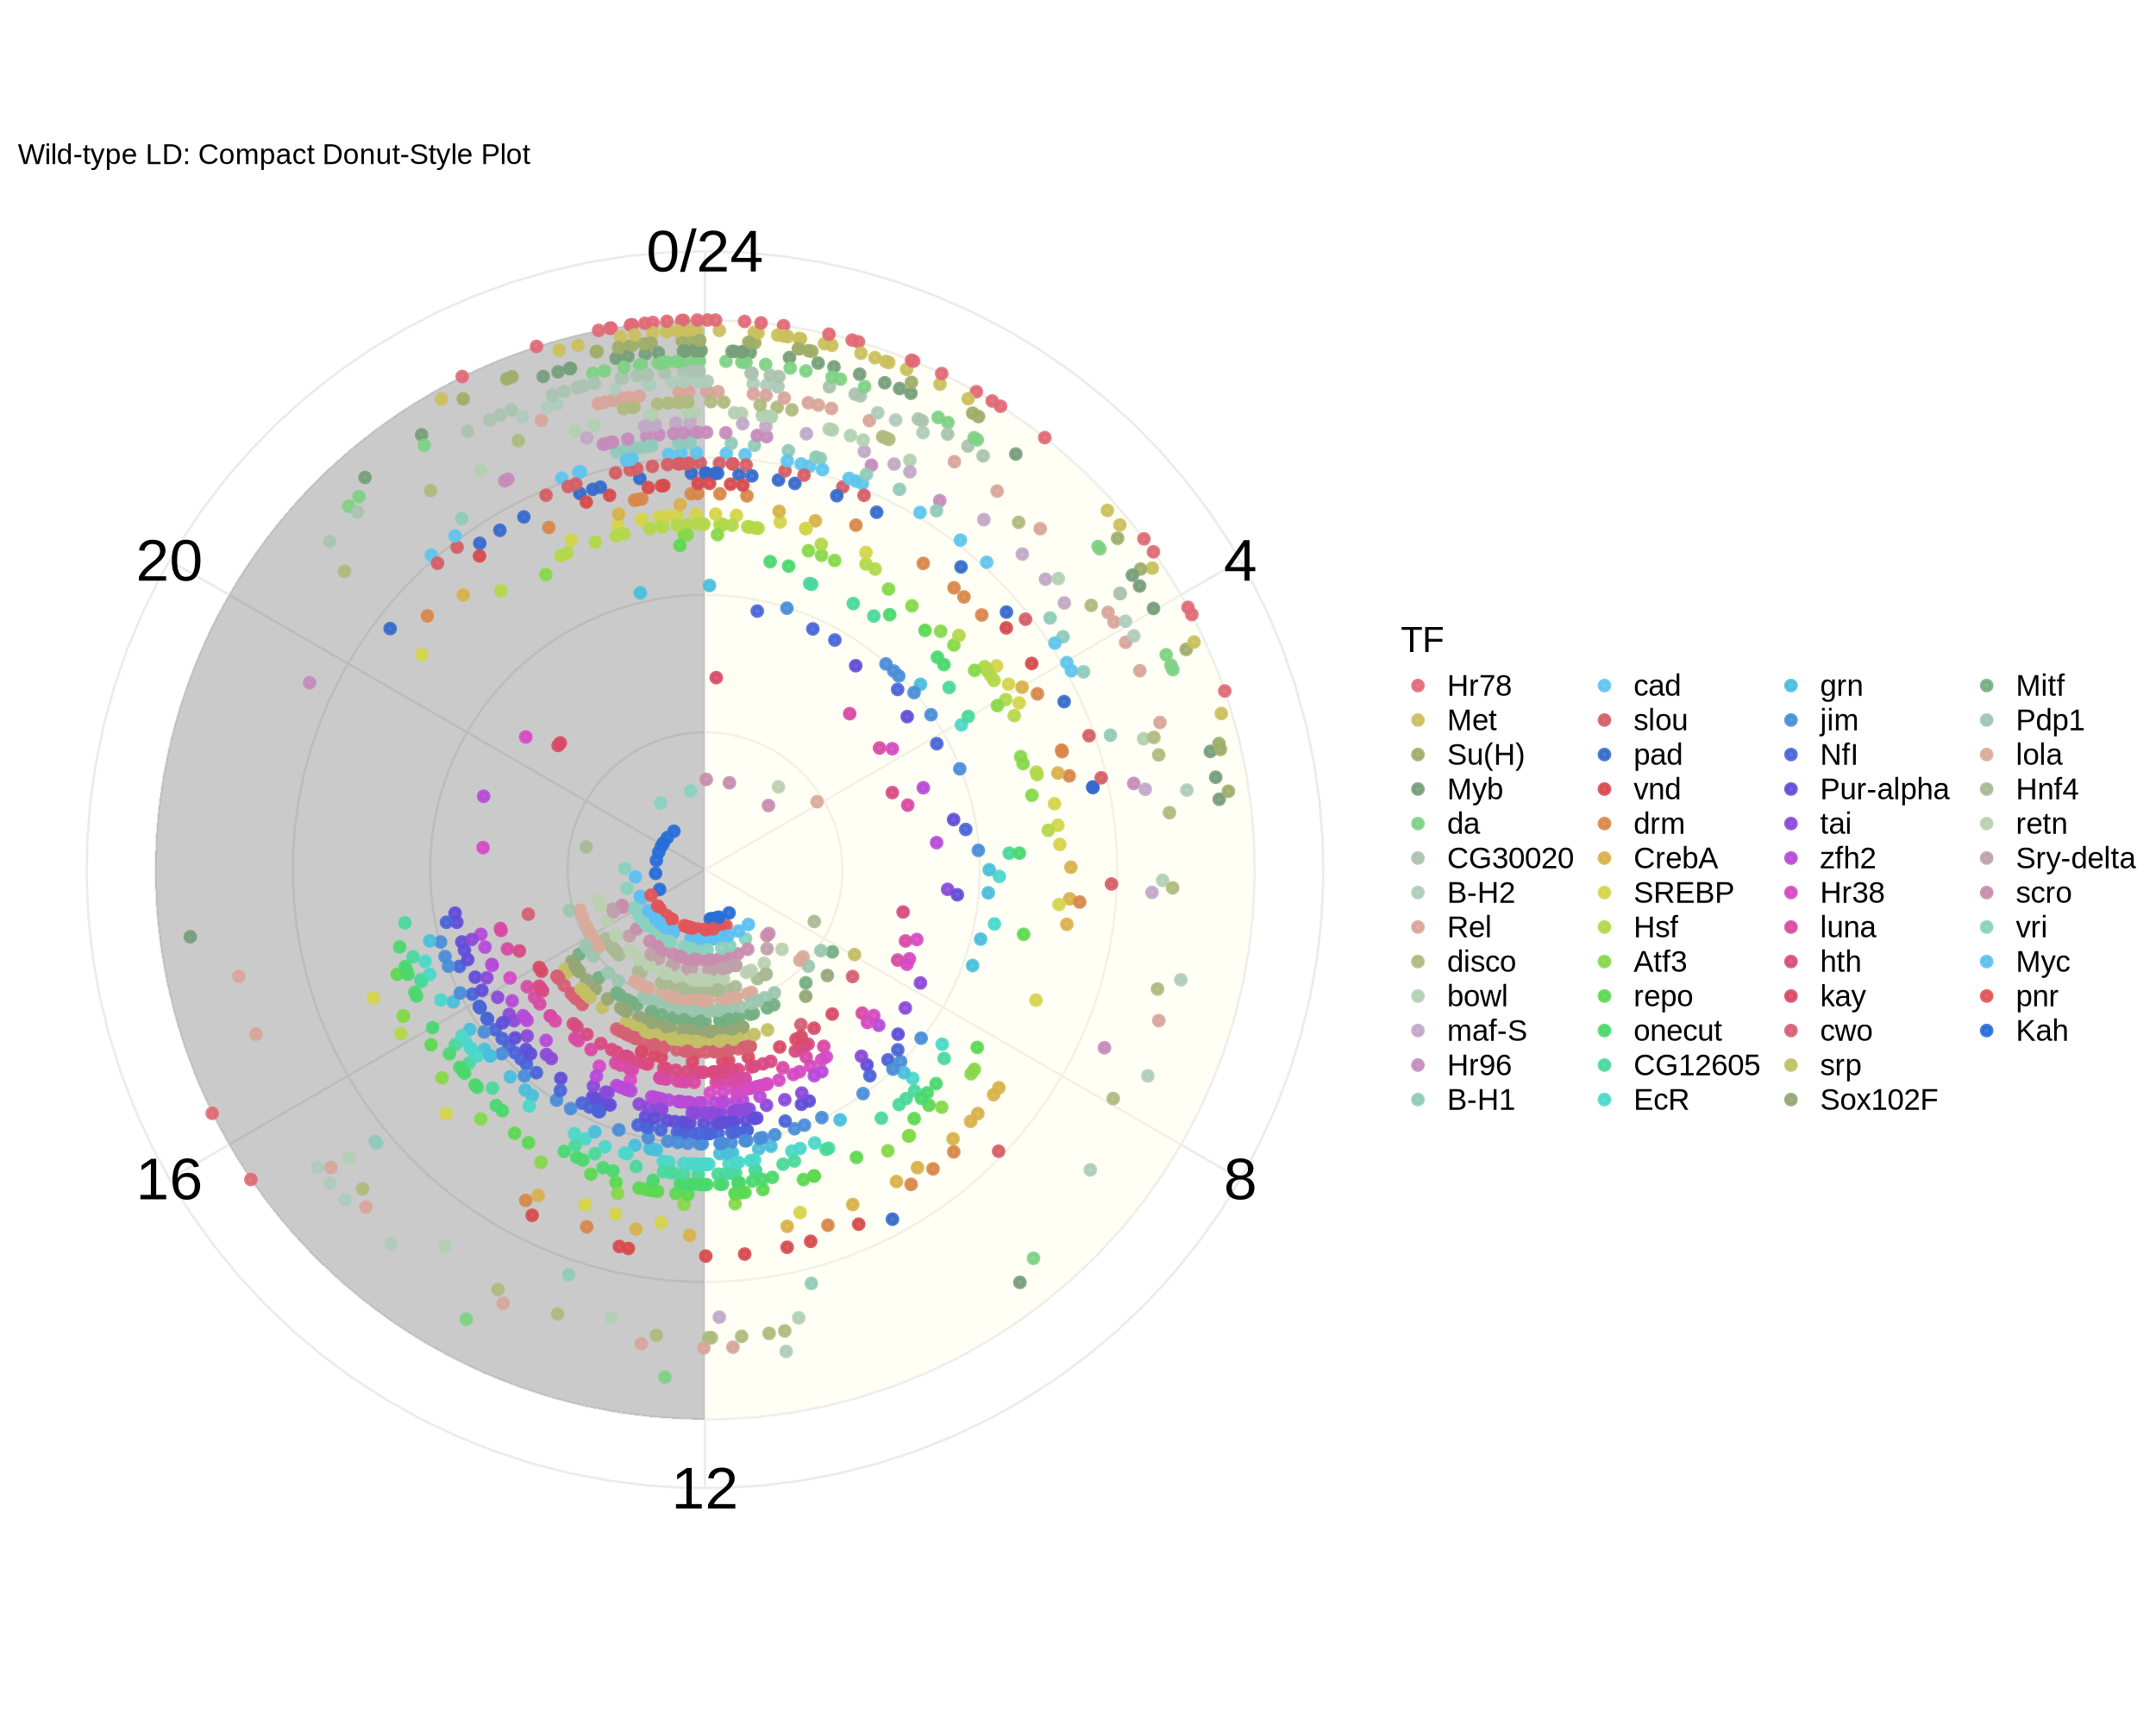

In [9]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c(
              "Hr78"#
              ,"Met"#
              ,"Su.H."# 
              ,"Myb" #            
              ,"da"#
              ,"CG30020"#
              ,"B.H2"#
              ,"Rel"#
              ,"disco"#
              ,"bowl"#
              ,"maf.S"#
              ,"Hr96"#
              ,"B.H1"#
              ,"cad"# controls Clk expression
              ,"slou"#
              ,"pad"#
              ,"vnd"#
              ,"drm"# 
              ,"CrebA"#
              ,"SREBP"
              ,"Hsf"
              ,"Atf3"
              ,"repo"
              ,"onecut"
              ,"CG12605"#
              ,"EcR"
              ,"grn"    
              ,"jim"
              ,"NfI"
              ,"Pur.alpha"
              ,"tai"
              ,"zfh2"
              ,"Hr38"
              ,"luna"#
              ,"hth"
              ,"kay"
              ,"cwo"
              ,"srp"
              ,"Sox102F"#
              ,"Mitf"#
              ,"Pdp1"
              ,"lola"#
              ,"Hnf4"
              ,"retn"#  
              ,"Sry.delta"#
              ,"scro"
              ,"vri"
              ,"Myc"#
              ,"pnr"
              ,"Kah"#
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "Su.H."     = "Su(H)",
  "B.H2"      = "B-H2",
  "maf.S"     = "maf-S",
  "B.H1"      = "B-H1",
  "Pur.alpha" = "Pur-alpha",
  "Sry.delta" = "Sry-delta"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.2,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
base_colors <- c("#e06b77", "#cec15e", "#a5b268", "#7a927d", "#6ddb77", "#b3b4b4",
                 "#99e7a7", "#d4a0e0", "#dead40", "#80c8c1", "#dcd8a5", "#b18adc",
                 "#cf8eab", "#7ae2bf", "#5abef9", "#ea4e4e", "#286ed8", "#db4b4b",
                 "#d8864b", "#d8ad4b", "#d8d54b", "#bcd84b", "#92d84b", "#68d84b",
                 "#4bd85d", "#4bd888", "#4bd8b3", "#4bd8de", "#4badd8", "#4b7fd8",
                 "#4b5bd8", "#684bd8", "#924bd8", "#bc4bd8", "#d84bc4", "#d84ba4",
                 "#d84b84", "#d84b64", "#d84877", "#cec55f", "#a5b173", "#7a927d",
                 "#6ddd8e", "#d4aada", "#dead5e", "#80c4c0", "#dcd8a7", "#b18aaa",
                 "#cf8faf", "#7ae0c3", "#5abaf9", "#ea4e4e", "#286ed8"
)
my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "Su.H."     = "Su(H)",
    "B.H2"      = "B-H2",
    "maf.S"     = "maf-S",
    "B.H1"      = "B-H1",
    "Pur.alpha" = "Pur-alpha",
    "Sry.delta" = "Sry-delta",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.4, alpha=0.9) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

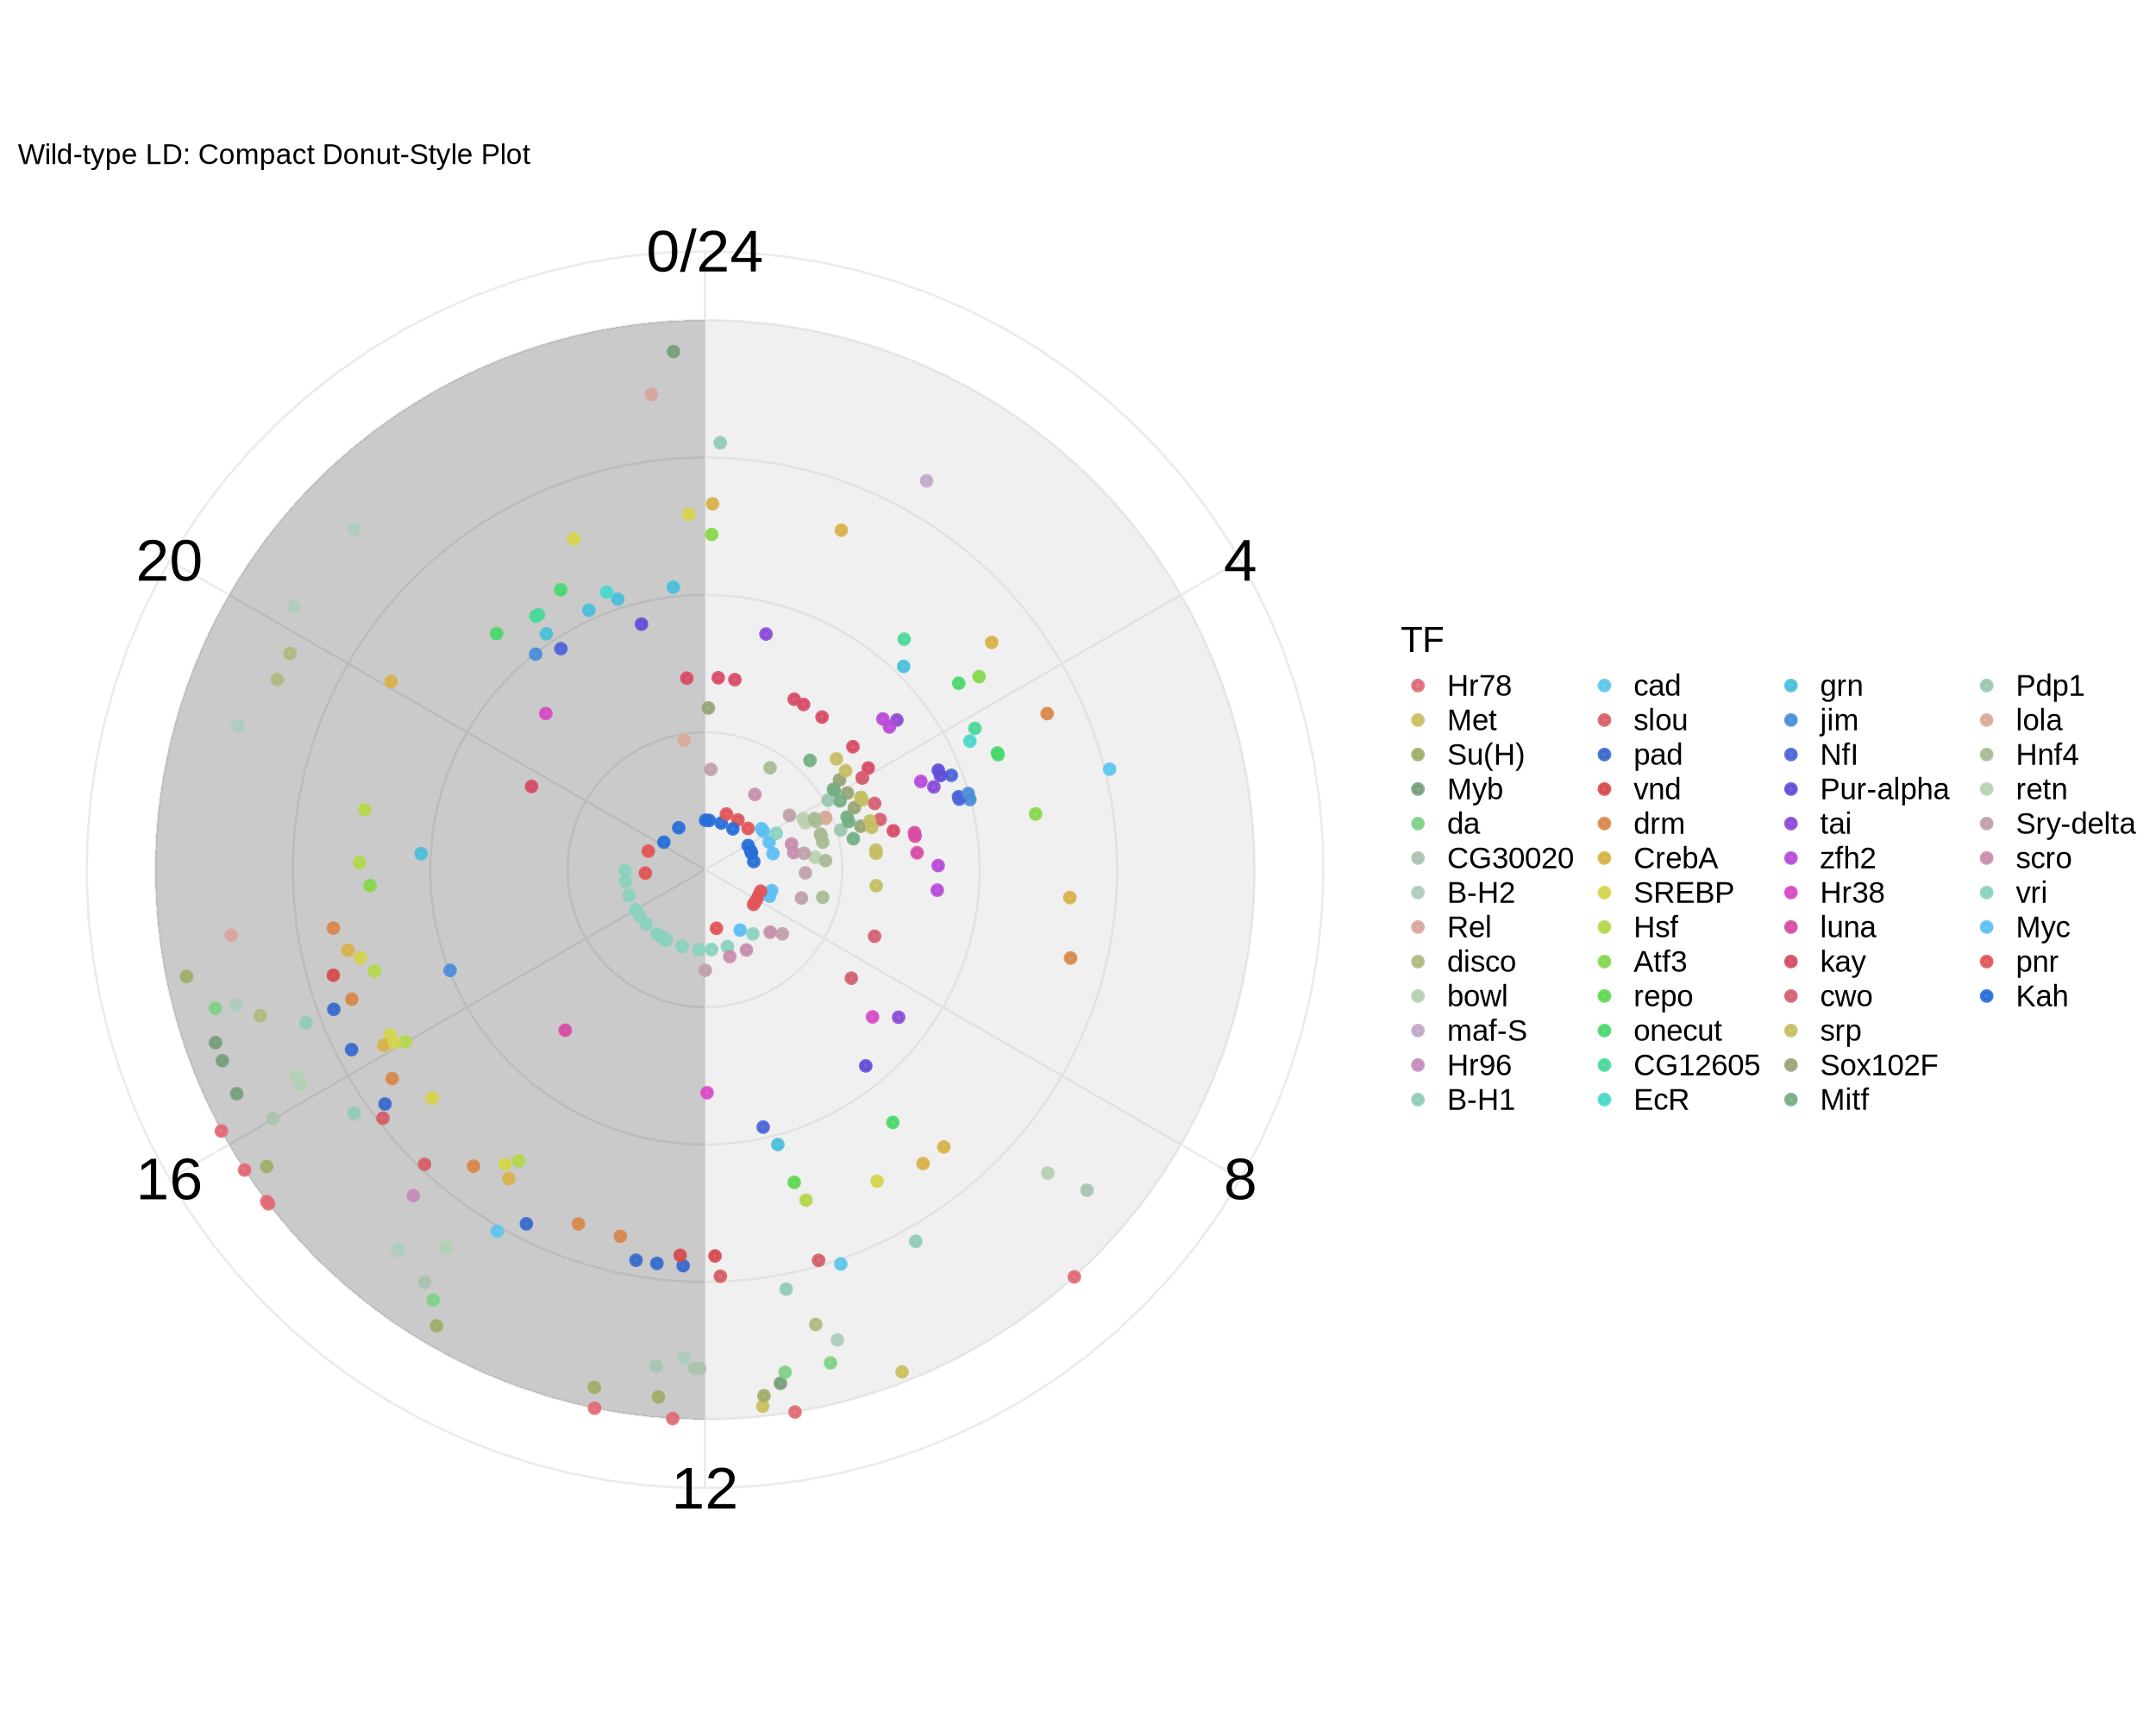

In [235]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c(
              "Hr78"#
              ,"Met"#
              ,"Su.H."# 
              ,"Myb" #            
              ,"da"#
              ,"CG30020"#
              ,"B.H2"#
              ,"Rel"#
              ,"disco"#
              ,"bowl"#
              ,"maf.S"#
              ,"Hr96"#
              ,"B.H1"#
              ,"cad"# controls Clk expression
              ,"slou"#
              ,"pad"#
              ,"vnd"#
              ,"drm"# 
              ,"CrebA"#
              ,"SREBP"
              ,"Hsf"
              ,"Atf3"
              ,"repo"
              ,"onecut"
              ,"CG12605"#
              ,"EcR"
              ,"grn"    
              ,"jim"
              ,"NfI"
              ,"Pur.alpha"
              ,"tai"
              ,"zfh2"
              ,"Hr38"
              ,"luna"#
              ,"hth"
              ,"kay"
              ,"cwo"
              ,"srp"
              ,"Sox102F"#
              ,"Mitf"#
              ,"Pdp1"
              ,"lola"#
              ,"Hnf4"
              ,"retn"#  
              ,"Sry.delta"#
              ,"scro"
              ,"vri"
              ,"Myc"#
              ,"pnr"
              ,"Kah"#
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "Su.H."     = "Su(H)",
  "B.H2"      = "B-H2",
  "maf.S"     = "maf-S",
  "B.H1"      = "B-H1",
  "Pur.alpha" = "Pur-alpha",
  "Sry.delta" = "Sry-delta"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.2,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
base_colors <- c("#e06b77", "#cec15e", "#a5b268", "#7a927d", "#6ddb77", "#b3b4b4",
                 "#99e7a7", "#d4a0e0", "#dead40", "#80c8c1", "#dcd8a5", "#b18adc",
                 "#cf8eab", "#7ae2bf", "#5abef9", "#ea4e4e", "#286ed8", "#db4b4b",
                 "#d8864b", "#d8ad4b", "#d8d54b", "#bcd84b", "#92d84b", "#68d84b",
                 "#4bd85d", "#4bd888", "#4bd8b3", "#4bd8de", "#4badd8", "#4b7fd8",
                 "#4b5bd8", "#684bd8", "#924bd8", "#bc4bd8", "#d84bc4", "#d84ba4",
                 "#d84b84", "#d84b64", "#d84877", "#cec55f", "#a5b173", "#7a927d",
                 "#6ddd8e", "#d4aada", "#dead5e", "#80c4c0", "#dcd8a7", "#b18aaa",
                 "#cf8faf", "#7ae0c3", "#5abaf9", "#ea4e4e", "#286ed8"
)
my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "Wild-type DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "Su.H."     = "Su(H)",
    "B.H2"      = "B-H2",
    "maf.S"     = "maf-S",
    "B.H1"      = "B-H1",
    "Pur.alpha" = "Pur-alpha",
    "Sry.delta" = "Sry-delta",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.4, alpha=0.9) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

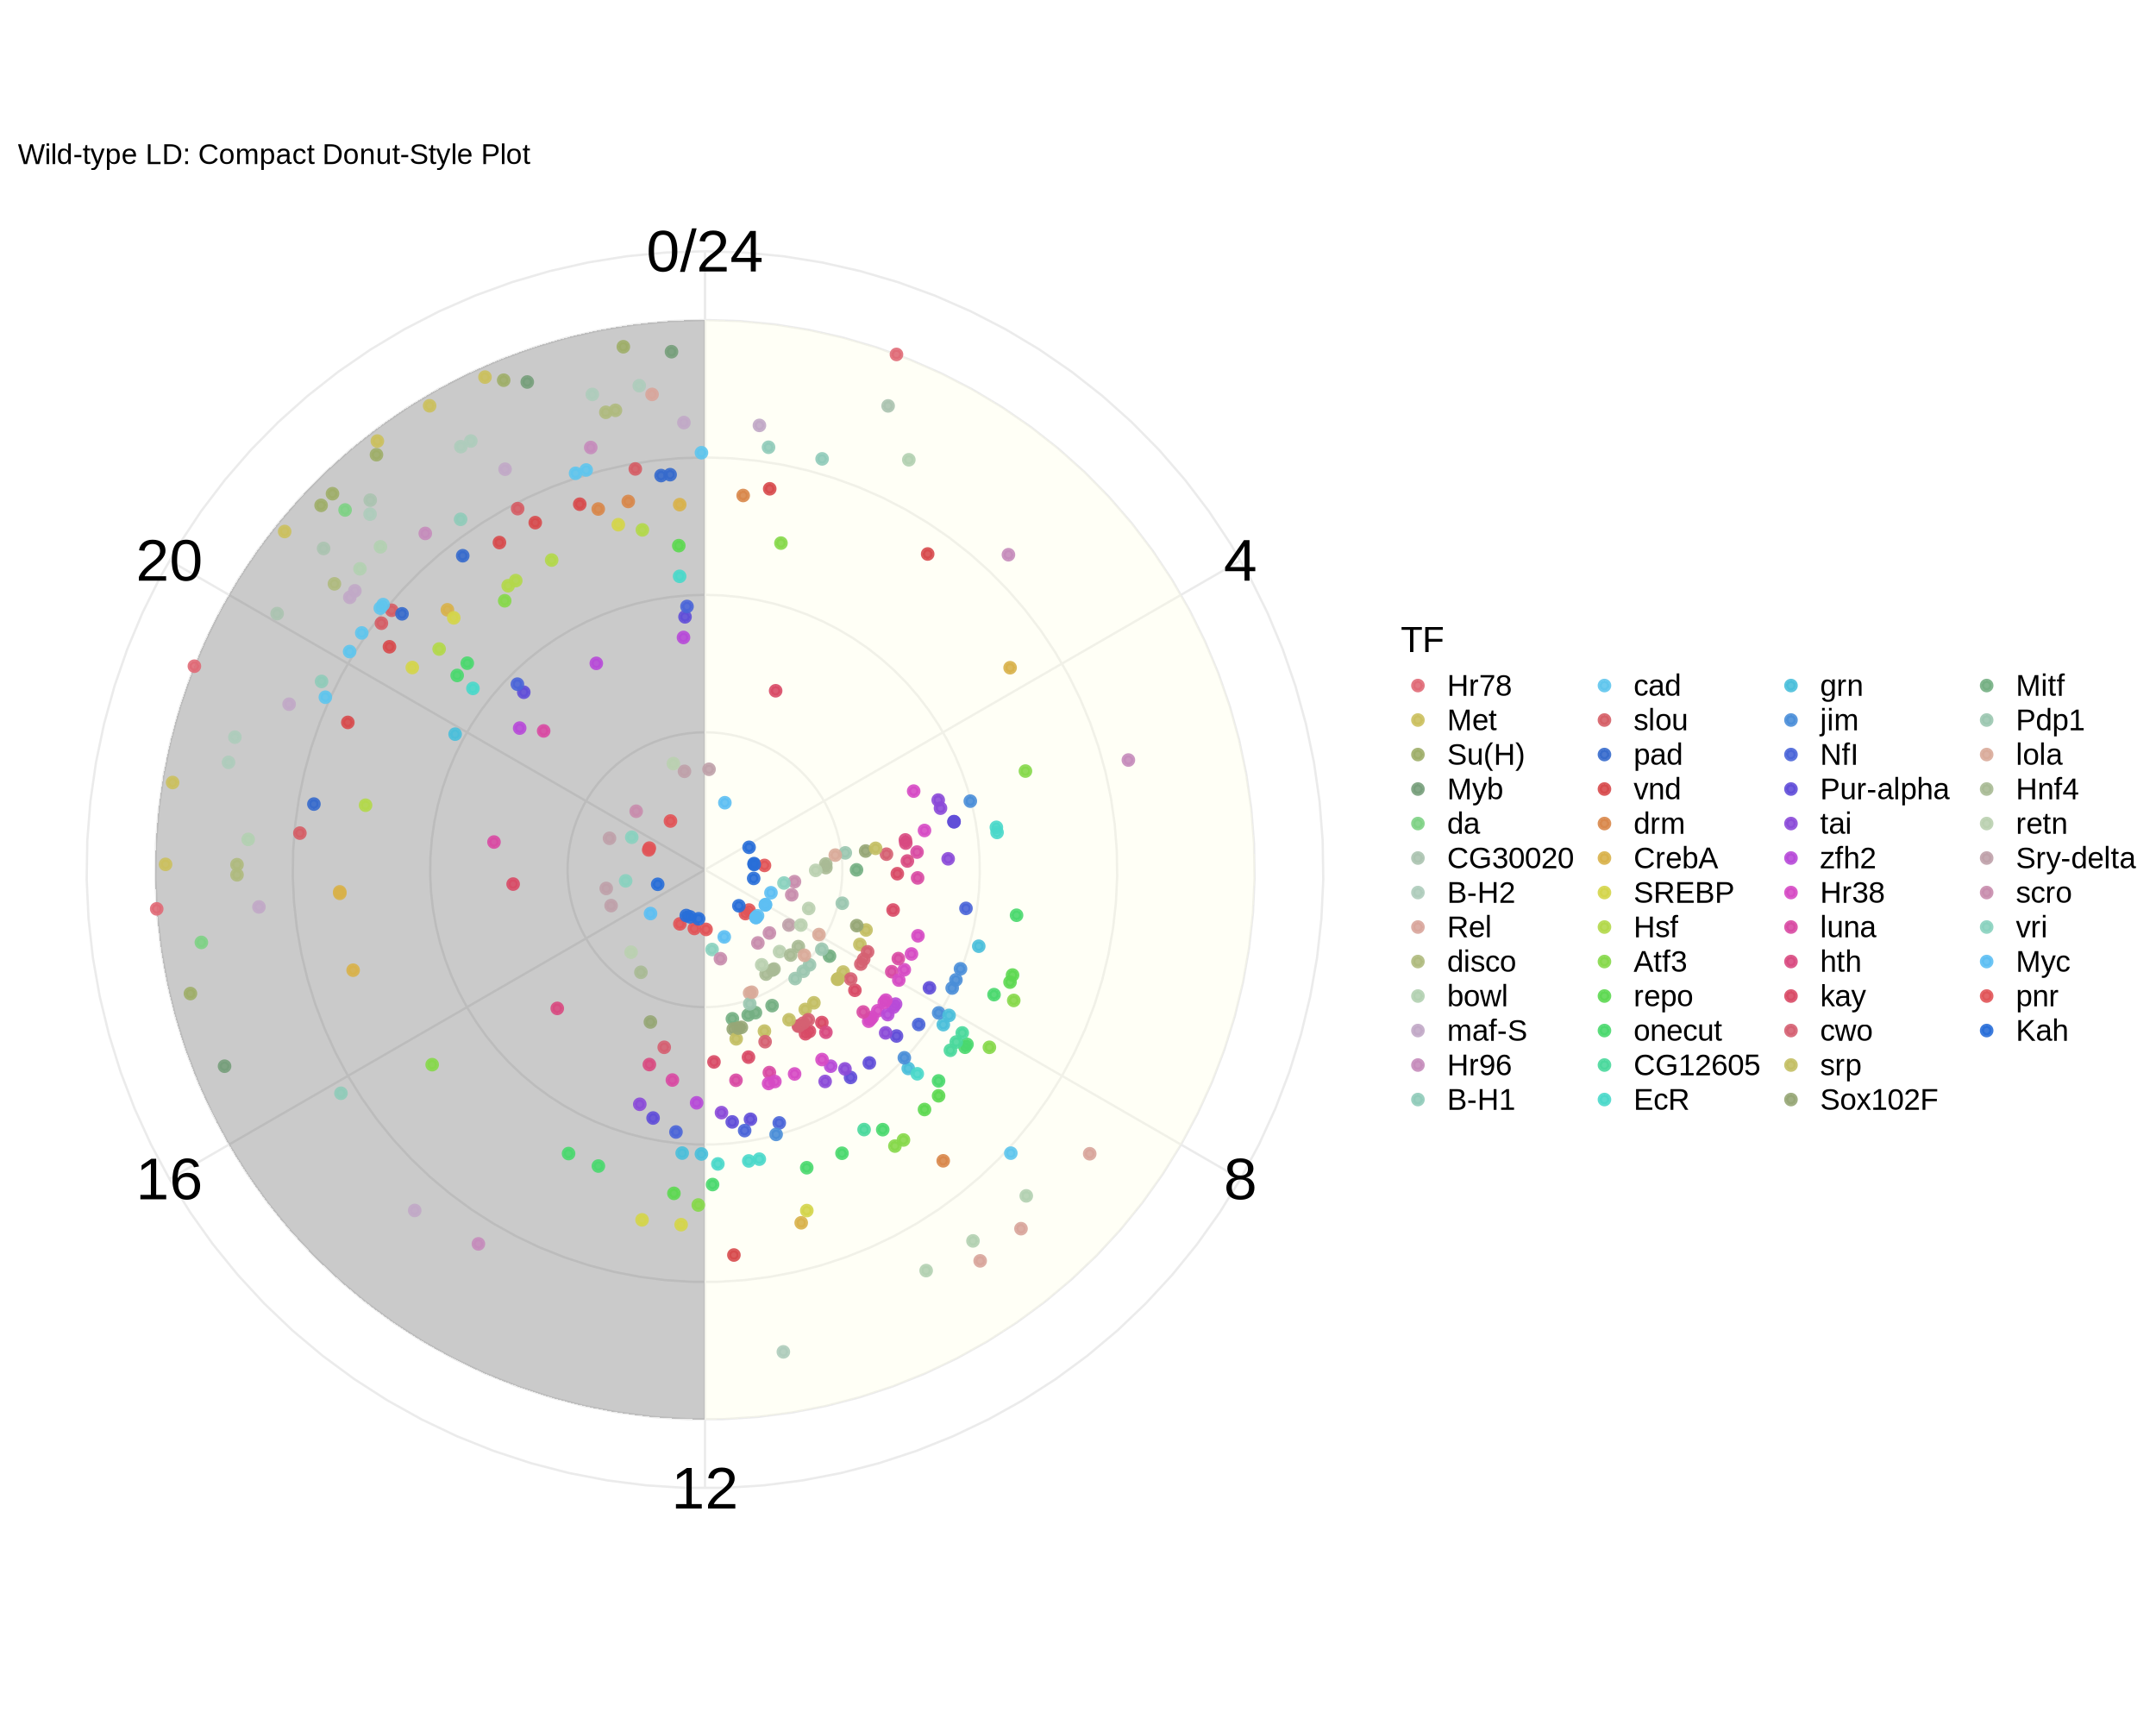

In [236]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c(
              "Hr78"#
              ,"Met"#
              ,"Su.H."# 
              ,"Myb" #            
              ,"da"#
              ,"CG30020"#
              ,"B.H2"#
              ,"Rel"#
              ,"disco"#
              ,"bowl"#
              ,"maf.S"#
              ,"Hr96"#
              ,"B.H1"#
              ,"cad"# controls Clk expression
              ,"slou"#
              ,"pad"#
              ,"vnd"#
              ,"drm"# 
              ,"CrebA"#
              ,"SREBP"
              ,"Hsf"
              ,"Atf3"
              ,"repo"
              ,"onecut"
              ,"CG12605"#
              ,"EcR"
              ,"grn"    
              ,"jim"
              ,"NfI"
              ,"Pur.alpha"
              ,"tai"
              ,"zfh2"
              ,"Hr38"
              ,"luna"#
              ,"hth"
              ,"kay"
              ,"cwo"
              ,"srp"
              ,"Sox102F"#
              ,"Mitf"#
              ,"Pdp1"
              ,"lola"#
              ,"Hnf4"
              ,"retn"#  
              ,"Sry.delta"#
              ,"scro"
              ,"vri"
              ,"Myc"#
              ,"pnr"
              ,"Kah"#
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "Su.H."     = "Su(H)",
  "B.H2"      = "B-H2",
  "maf.S"     = "maf-S",
  "B.H1"      = "B-H1",
  "Pur.alpha" = "Pur-alpha",
  "Sry.delta" = "Sry-delta"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.2,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
base_colors <- c("#e06b77", "#cec15e", "#a5b268", "#7a927d", "#6ddb77", "#b3b4b4",
                 "#99e7a7", "#d4a0e0", "#dead40", "#80c8c1", "#dcd8a5", "#b18adc",
                 "#cf8eab", "#7ae2bf", "#5abef9", "#ea4e4e", "#286ed8", "#db4b4b",
                 "#d8864b", "#d8ad4b", "#d8d54b", "#bcd84b", "#92d84b", "#68d84b",
                 "#4bd85d", "#4bd888", "#4bd8b3", "#4bd8de", "#4badd8", "#4b7fd8",
                 "#4b5bd8", "#684bd8", "#924bd8", "#bc4bd8", "#d84bc4", "#d84ba4",
                 "#d84b84", "#d84b64", "#d84877", "#cec55f", "#a5b173", "#7a927d",
                 "#6ddd8e", "#d4aada", "#dead5e", "#80c4c0", "#dcd8a7", "#b18aaa",
                 "#cf8faf", "#7ae0c3", "#5abaf9", "#ea4e4e", "#286ed8"
)
my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 LD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "Su.H."     = "Su(H)",
    "B.H2"      = "B-H2",
    "maf.S"     = "maf-S",
    "B.H1"      = "B-H1",
    "Pur.alpha" = "Pur-alpha",
    "Sry.delta" = "Sry-delta",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="lightyellow", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.4, alpha=0.9) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)

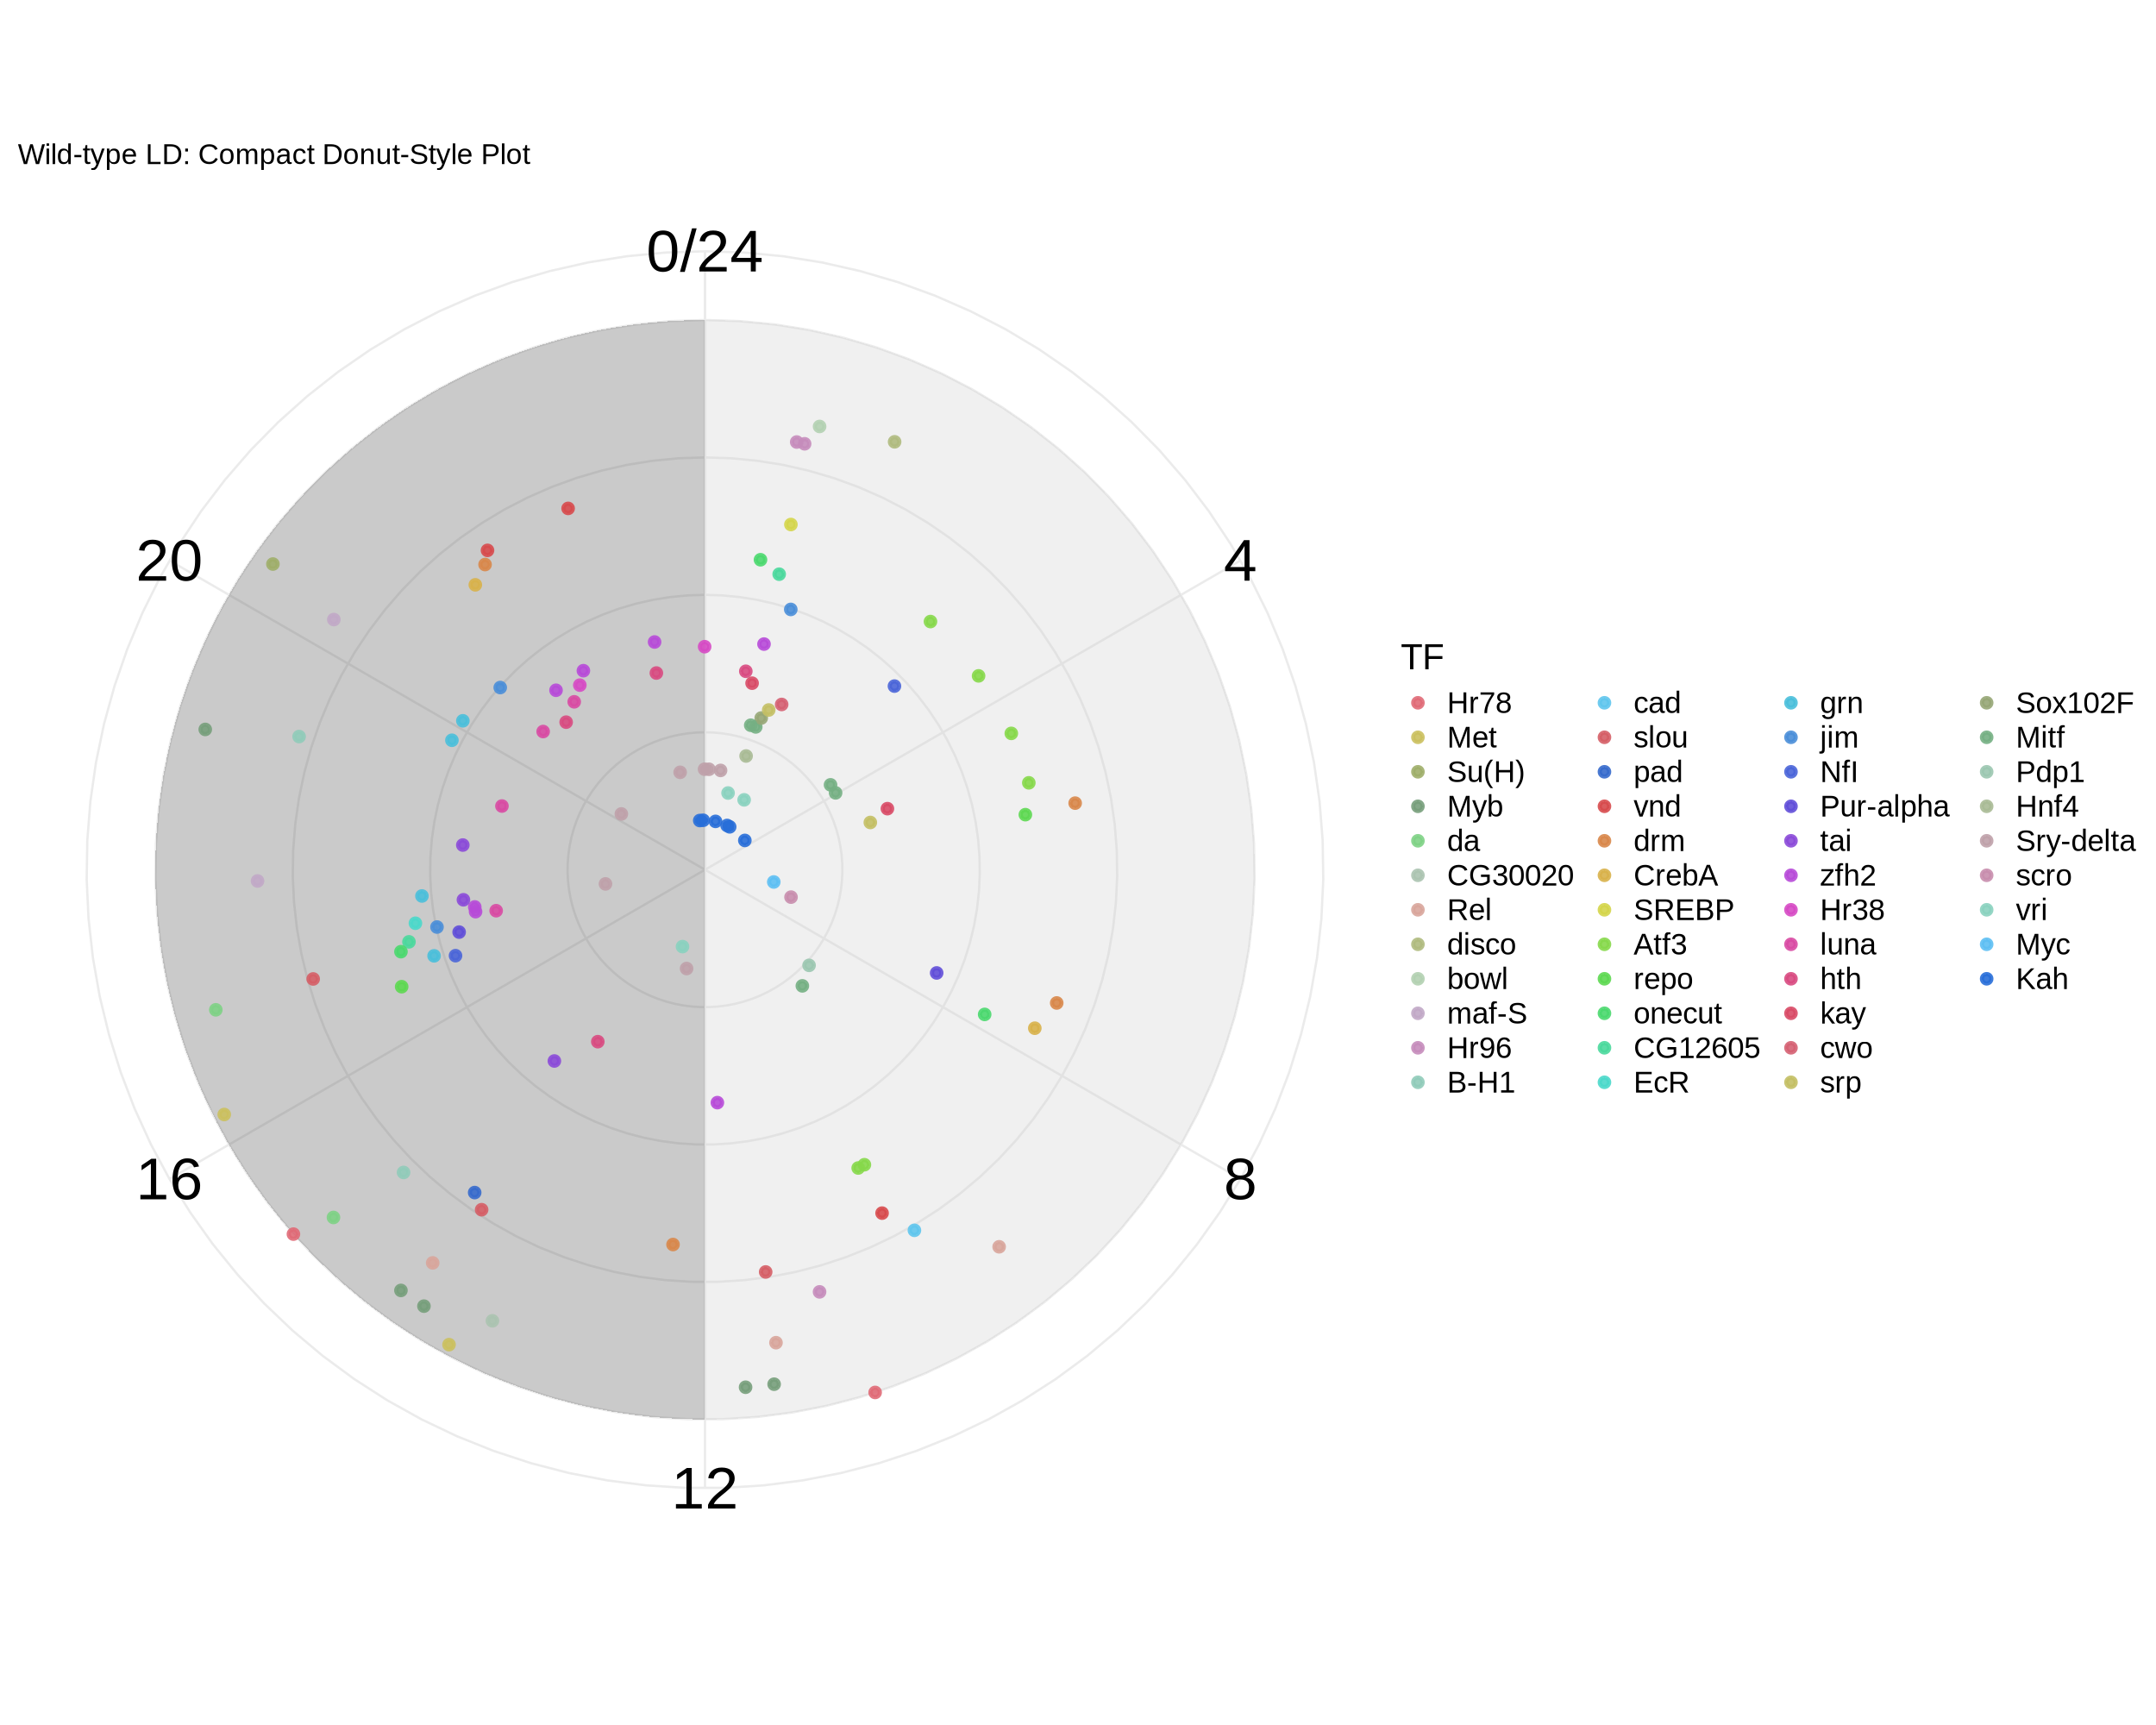

In [237]:
library(dplyr)
library(ggplot2)

# 1) Your full, fixed ordering of TFs:
# Base 14 colors you provided

# Create a color palette of length 17 by interpolating the 14 base colors
raw_tf <-  c(
              "Hr78"#
              ,"Met"#
              ,"Su.H."# 
              ,"Myb" #            
              ,"da"#
              ,"CG30020"#
              ,"B.H2"#
              ,"Rel"#
              ,"disco"#
              ,"bowl"#
              ,"maf.S"#
              ,"Hr96"#
              ,"B.H1"#
              ,"cad"# controls Clk expression
              ,"slou"#
              ,"pad"#
              ,"vnd"#
              ,"drm"# 
              ,"CrebA"#
              ,"SREBP"
              ,"Hsf"
              ,"Atf3"
              ,"repo"
              ,"onecut"
              ,"CG12605"#
              ,"EcR"
              ,"grn"    
              ,"jim"
              ,"NfI"
              ,"Pur.alpha"
              ,"tai"
              ,"zfh2"
              ,"Hr38"
              ,"luna"#
              ,"hth"
              ,"kay"
              ,"cwo"
              ,"srp"
              ,"Sox102F"#
              ,"Mitf"#
              ,"Pdp1"
              ,"lola"#
              ,"Hnf4"
              ,"retn"#  
              ,"Sry.delta"#
              ,"scro"
              ,"vri"
              ,"Myc"#
              ,"pnr"
              ,"Kah"#
             )
# 2) Recode those names once and for all:
tf_order <- recode(
  raw_tf,
  "Su.H."     = "Su(H)",
  "B.H2"      = "B-H2",
  "maf.S"     = "maf-S",
  "B.H1"      = "B-H1",
  "Pur.alpha" = "Pur-alpha",
  "Sry.delta" = "Sry-delta"
)
# Now tf_order is exactly the vector of names you want

# 3) Build your radius map off of tf_order
nTFs       <- length(tf_order)
radius_map <- setNames(seq(0,18.2,length.out=nTFs), tf_order)

# 4) Build your palette *and* name it by the same tf_order
base_colors <- c("#e06b77", "#cec15e", "#a5b268", "#7a927d", "#6ddb77", "#b3b4b4",
                 "#99e7a7", "#d4a0e0", "#dead40", "#80c8c1", "#dcd8a5", "#b18adc",
                 "#cf8eab", "#7ae2bf", "#5abef9", "#ea4e4e", "#286ed8", "#db4b4b",
                 "#d8864b", "#d8ad4b", "#d8d54b", "#bcd84b", "#92d84b", "#68d84b",
                 "#4bd85d", "#4bd888", "#4bd8b3", "#4bd8de", "#4badd8", "#4b7fd8",
                 "#4b5bd8", "#684bd8", "#924bd8", "#bc4bd8", "#d84bc4", "#d84ba4",
                 "#d84b84", "#d84b64", "#d84877", "#cec55f", "#a5b173", "#7a927d",
                 "#6ddd8e", "#d4aada", "#dead5e", "#80c4c0", "#dcd8a7", "#b18aaa",
                 "#cf8faf", "#7ae0c3", "#5abaf9", "#ea4e4e", "#286ed8"
)
my_pal <- colorRampPalette(base_colors)(nTFs)
names(my_pal) <- tf_order     # ***important***

# 5) Now subset & plot, using the recoded tf_order everywhere
cond_data <- sig_results %>%
  filter(Condition == "per0 DD") %>%
  # recode your data column *exactly* the same way
  mutate(CycID = recode(
    CycID,
    "Su.H."     = "Su(H)",
    "B.H2"      = "B-H2",
    "maf.S"     = "maf-S",
    "B.H1"      = "B-H1",
    "Pur.alpha" = "Pur-alpha",
    "Sry.delta" = "Sry-delta",
    .default    = CycID
  )) %>%
  filter(CycID %in% tf_order) %>%
  mutate(
    TF        = factor(CycID, levels = tf_order),
    phase_deg = 360 * avg_phase / 24,
    radius    = radius_map[as.character(CycID)]
  )

p <- ggplot(cond_data, aes(x=phase_deg, y=radius, color=TF)) +
  annotate("rect", xmin=0,   xmax=180, ymin=-Inf, ymax=Inf,
           fill="gray80", alpha=0.3) +
  annotate("rect", xmin=180, xmax=360, ymin=-Inf, ymax=Inf,
           fill="gray30", alpha=0.3) +
  geom_point(size=0.4, alpha=0.9) +
  scale_x_continuous(limits=c(0,360),
                     breaks=seq(0,360,60),
                     labels=seq(0,24,4)) +
  scale_y_reverse(limits=c(20,0), expand=c(0,0)) +
  coord_polar(theta="x", start=0, clip="off") +
  scale_color_manual(
    values = my_pal,
    breaks = tf_order
  ) +
  theme_minimal(base_size=4) +
  theme(
    aspect.ratio       = 1,
    panel.grid.minor   = element_blank(),
    axis.title         = element_blank(),
    axis.text.x        = element_text(color="black", size=10),
    axis.text.y        = element_blank(),
    plot.background    = element_rect(fill="transparent", color=NA),
    panel.background   = element_rect(fill="transparent", color=NA),
    legend.key.size    = unit(0.4,"lines"),
    legend.spacing     = unit(0.1,"lines"),
    legend.margin      = margin(0,0,0,0),
    legend.text        = element_text(size=5),
    legend.title       = element_text(size=6),
    legend.box.spacing = unit(0.1,"lines")
  ) +
  guides(color = guide_legend(ncol=4, keyheight=unit(0.4,"lines"),
                              keywidth=unit(0.4,"lines"),
                              default.unit="lines")) +
  labs(title="Wild-type LD: Compact Donut-Style Plot", color="TF")

print(p)